In [27]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Add scripts directory to path
sys.path.insert(0, '../scripts')

from query_temperature import (
    load_deployment_data,
    load_sensor_data,
    load_time_range_data,
    list_deployments,
    list_sensors
)

## Configuration

In [28]:
# Path to your database
DB_PATH = '/Users/abdullaalhosani/Projects/highz/temperature.db'

# Deployment to analyze
DEPLOYMENT = 'Adak_2025Dec'

## 1. List Available Data

In [29]:
# List all deployments
deployments = list_deployments(DB_PATH)
print("Available deployments:")
display(deployments)

Available deployments:


,deployment_id,name,site,timezone_name,num_sensors,num_readings,first_reading_utc,last_reading_utc
0,1,Adak_2025Dec,Adak,America/New_York,3,25105,2025-12-11 16:34:14,2026-01-09 18:06:04
1,2,LunarDryLake_2024Dec,LunarDryLake,America/New_York,3,34565,2024-12-04 22:07:58,2025-01-13 22:27:58
2,3,LunarDryLake_2025Nov,LunarDryLake,America/New_York,1,20676,2025-09-30 21:24:39,2025-12-11 15:19:39


In [30]:
# List all sensors
sensors = list_sensors(DB_PATH)
print("Available sensors:")
display(sensors)

Available sensors:


,sensor_id,sensor_type,part_number,registration_number,label,num_deployments,num_readings
0,3,ibutton_ds1925,DS1925,0C00000011B43C53,RFBox,1,8364
1,6,ibutton_ds1925,DS1925,7200000011969F53,FilterBank,1,20676
2,4,ibutton_ds1925,DS1925,900000001041F753,DigitalSpec,1,11518
3,1,ibutton_ds1925,DS1925,B4000000100B1453,Antenna,2,19892
4,5,ibutton_ds1925,DS1925,B80000001003B653,RFBox,1,11525
5,2,ibutton_ds1925,DS1925,BF00000011968653,DigitalSpec,1,8371


## 2. Load Deployment Data

In [31]:
# Load all temperature data for a deployment
df = load_deployment_data(DB_PATH, DEPLOYMENT)

print(f"Loaded {len(df):,} temperature readings")
print(f"Unique sensors: {df['sensor_registration'].nunique()}")
print(f"Time range: {df['time_utc_iso'].min()} to {df['time_utc_iso'].max()}")
print(f"Temperature range: {df['value_c'].min():.1f}°C to {df['value_c'].max():.1f}°C")

df.head()

Loaded 25,105 temperature readings
Unique sensors: 3
Time range: 2025-12-11 16:34:14 to 2026-01-09 18:06:04
Temperature range: -17.8°C to 35.8°C


,time_utc,time_utc_iso,time_local_text,value_c,sensor_registration,sensor_label,quality_flag
0,1765470854,2025-12-11 16:34:14,12/11/25 11:34:14 AM,27.438,B4000000100B1453,Antenna,0
1,1765470964,2025-12-11 16:36:04,12/11/25 11:36:04 AM,26.375,BF00000011968653,DigitalSpec,0
2,1765471141,2025-12-11 16:39:01,12/11/25 11:39:01 AM,26.875,0C00000011B43C53,RFBox,0
3,1765471154,2025-12-11 16:39:14,12/11/25 11:39:14 AM,24.188,B4000000100B1453,Antenna,0
4,1765471264,2025-12-11 16:41:04,12/11/25 11:41:04 AM,23.625,BF00000011968653,DigitalSpec,0


## 3. Basic Statistics

In [32]:
# Temperature statistics by sensor
stats = df.groupby('sensor_registration')['value_c'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max')
]).round(2)

print("Temperature statistics by sensor:")
display(stats)

Temperature statistics by sensor:


,count,mean,std,min,max
sensor_registration,,,,,
0C00000011B43C53,8364,10.25,7.30,-17.81,28.44
B4000000100B1453,8370,9.09,7.47,-1.56,31.25
BF00000011968653,8371,18.22,4.41,4.75,35.81


## 4. Plot Temperature Over Time

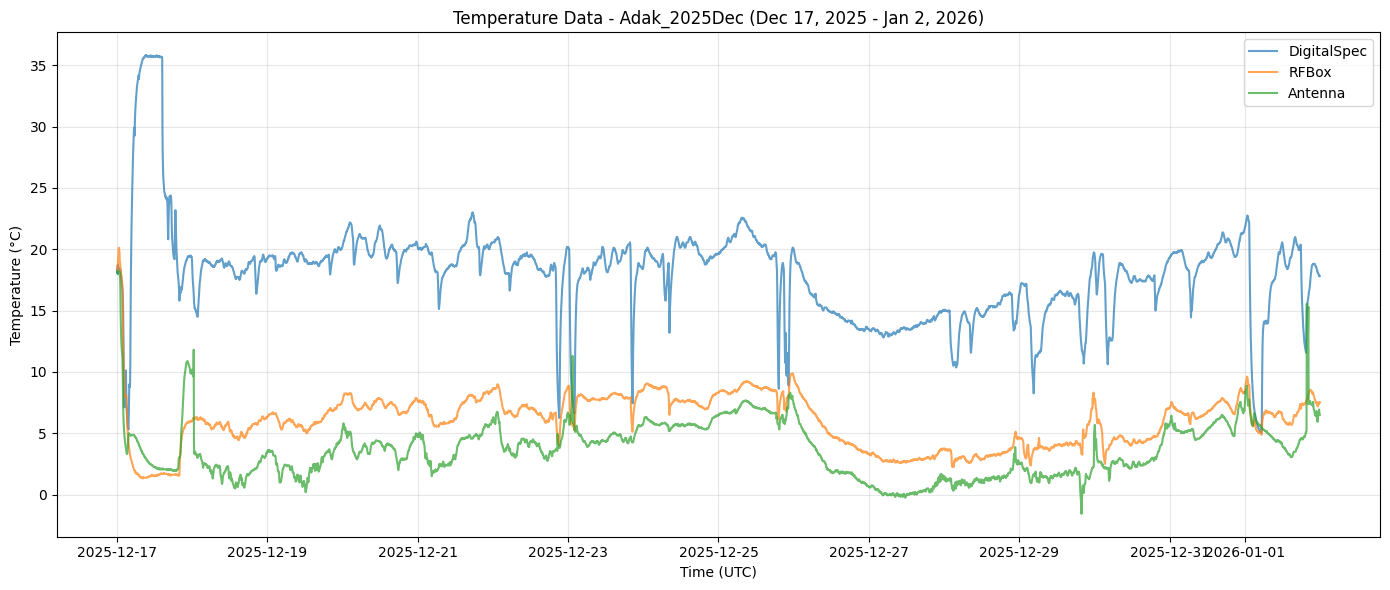

In [40]:
# Convert UTC to datetime for plotting
df['datetime_utc'] = pd.to_datetime(df['time_utc'], unit='s', utc=True)

# Filter to Dec 17, 2025 - Jan 2, 2026
start_date = pd.Timestamp('2025-12-17', tz='UTC')
end_date = pd.Timestamp('2026-01-02', tz='UTC')
df_filtered = df[(df['datetime_utc'] >= start_date) & (df['datetime_utc'] <= end_date)]

# Plot each sensor
plt.figure(figsize=(14, 6))

for sensor in df_filtered['sensor_registration'].unique():
    sensor_data = df_filtered[df_filtered['sensor_registration'] == sensor]
    label = sensor_data['sensor_label'].iloc[0] if sensor_data['sensor_label'].iloc[0] else sensor
    plt.plot(sensor_data['datetime_utc'], sensor_data['value_c'], label=label, alpha=0.7)

plt.xlabel('Time (UTC)')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Data - {DEPLOYMENT} (Dec 17, 2025 - Jan 2, 2026)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Compare Sensors

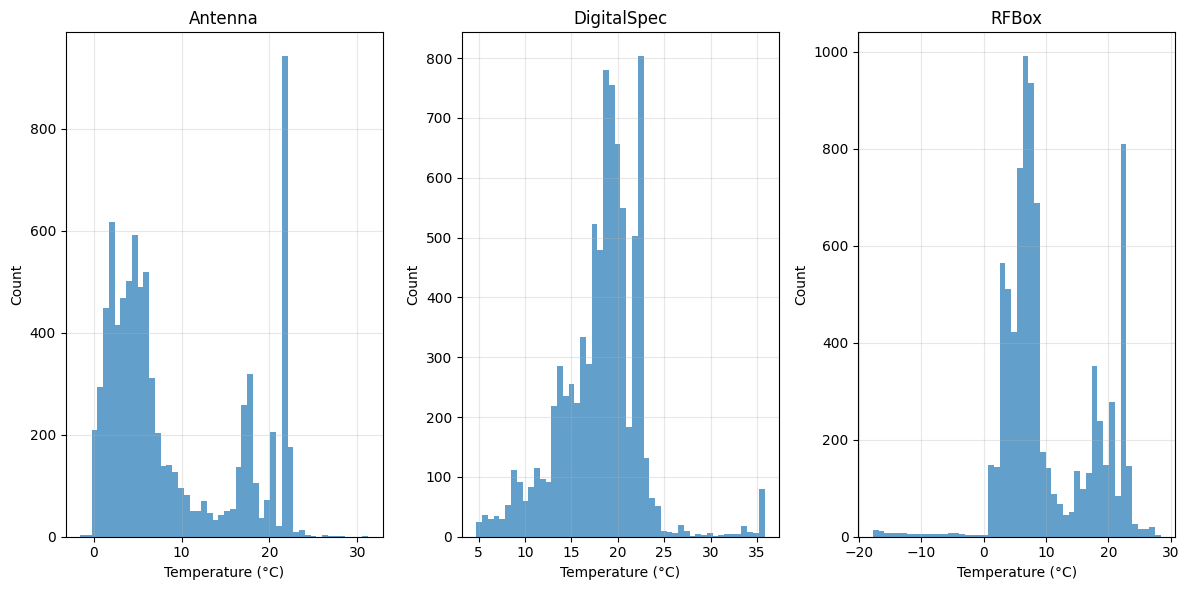

In [34]:
# Temperature distribution by sensor
plt.figure(figsize=(12, 6))

for i, sensor in enumerate(df['sensor_registration'].unique(), 1):
    sensor_data = df[df['sensor_registration'] == sensor]
    label = sensor_data['sensor_label'].iloc[0] if sensor_data['sensor_label'].iloc[0] else sensor
    plt.subplot(1, len(df['sensor_registration'].unique()), i)
    plt.hist(sensor_data['value_c'], bins=50, alpha=0.7)
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Count')
    plt.title(label)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Load Specific Sensor Data

In [35]:
# Get first sensor registration number
sensor_reg = df['sensor_registration'].iloc[0]

# Load all data for this sensor (across all deployments)
sensor_df = load_sensor_data(DB_PATH, sensor_reg)

print(f"Sensor: {sensor_reg}")
print(f"Deployments: {sensor_df['deployment_name'].unique()}")
print(f"Total readings: {len(sensor_df):,}")

sensor_df.head()

Sensor: B4000000100B1453
Deployments: ['LunarDryLake_2024Dec' 'Adak_2025Dec']
Total readings: 19,892


,time_utc,time_utc_iso,time_local_text,value_c,deployment_name,site,quality_flag
0,1733350536,2024-12-04 22:15:36,12/4/24 5:15:36 PM,27.188,LunarDryLake_2024Dec,LunarDryLake,0
1,1733350836,2024-12-04 22:20:36,12/4/24 5:20:36 PM,23.875,LunarDryLake_2024Dec,LunarDryLake,0
2,1733351136,2024-12-04 22:25:36,12/4/24 5:25:36 PM,23.875,LunarDryLake_2024Dec,LunarDryLake,0
3,1733351436,2024-12-04 22:30:36,12/4/24 5:30:36 PM,23.875,LunarDryLake_2024Dec,LunarDryLake,0
4,1733351736,2024-12-04 22:35:36,12/4/24 5:35:36 PM,23.875,LunarDryLake_2024Dec,LunarDryLake,0


## 7. Time Range Queries

First day readings: 0


/var/folders/3c/nwzhzfzj3v7ffnzxbxgq4mm80000gn/T/ipykernel_31186/2039501519.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


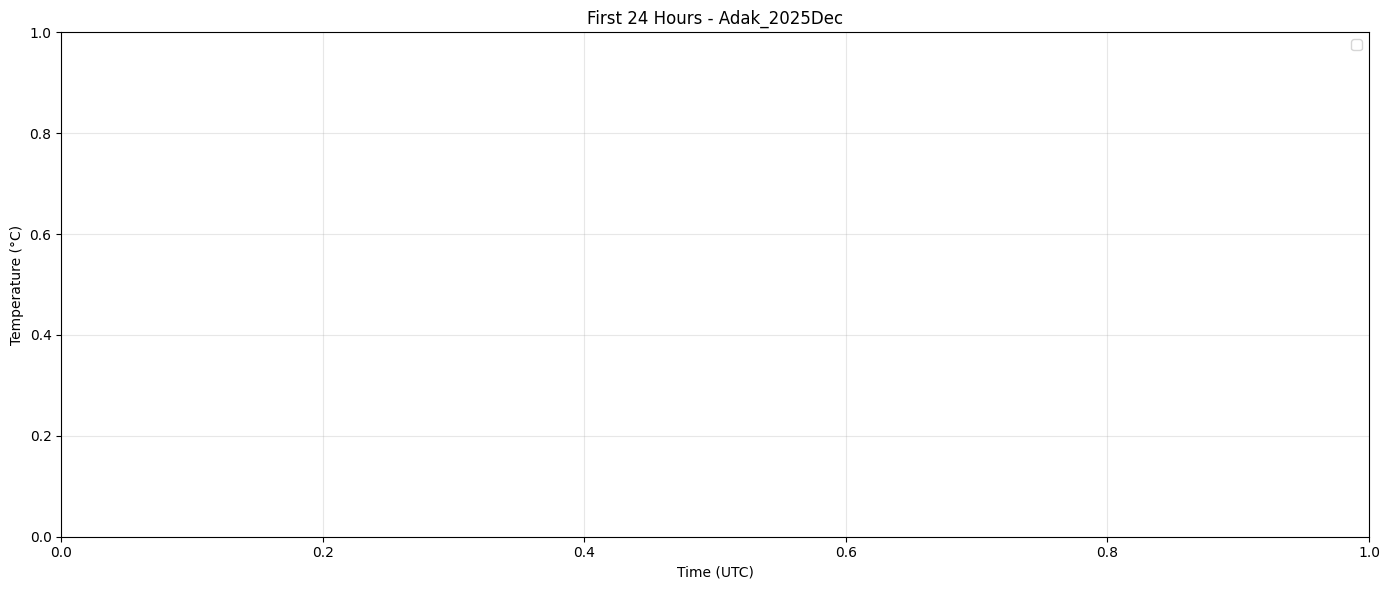

In [36]:
# Query specific time range (example: first day of deployment)
start_time = df['time_utc'].min()
end_time = start_time + 86400  # +24 hours

day1_df = load_time_range_data(DB_PATH, start_time, end_time, DEPLOYMENT)

print(f"First day readings: {len(day1_df):,}")

# Plot first day
plt.figure(figsize=(14, 6))
day1_df['datetime_utc'] = pd.to_datetime(day1_df['time_utc'], unit='s', utc=True)

for sensor in day1_df['sensor_registration'].unique():
    sensor_data = day1_df[day1_df['sensor_registration'] == sensor]
    label = sensor_data['sensor_label'].iloc[0] if sensor_data['sensor_label'].iloc[0] else sensor
    plt.plot(sensor_data['datetime_utc'], sensor_data['value_c'], label=label, marker='.')

plt.xlabel('Time (UTC)')
plt.ylabel('Temperature (°C)')
plt.title(f'First 24 Hours - {DEPLOYMENT}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Convert to Local Time for Display

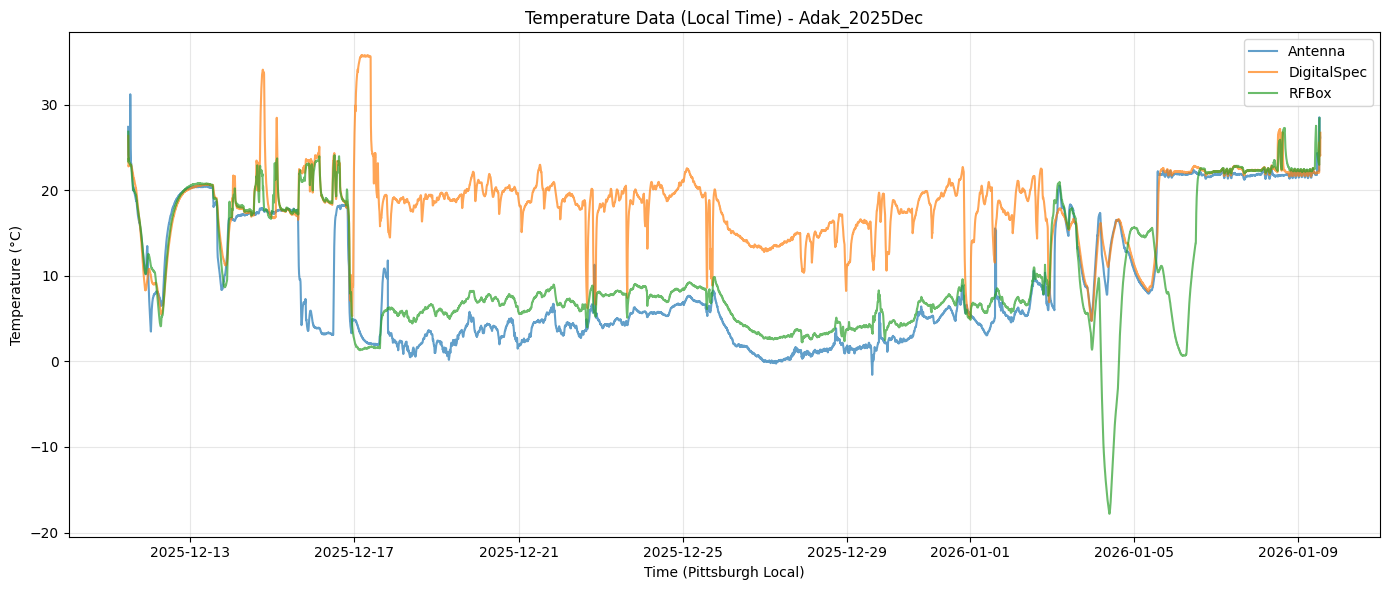

In [37]:
from zoneinfo import ZoneInfo

# Convert UTC to Pittsburgh local time
df['datetime_local'] = pd.to_datetime(df['time_utc'], unit='s', utc=True).dt.tz_convert('America/New_York')

# Plot in local time
plt.figure(figsize=(14, 6))

for sensor in df['sensor_registration'].unique():
    sensor_data = df[df['sensor_registration'] == sensor]
    label = sensor_data['sensor_label'].iloc[0] if sensor_data['sensor_label'].iloc[0] else sensor
    plt.plot(sensor_data['datetime_local'], sensor_data['value_c'], label=label, alpha=0.7)

plt.xlabel('Time (Pittsburgh Local)')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Data (Local Time) - {DEPLOYMENT}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Export Data

In [38]:
# Export to CSV
output_file = f'{DEPLOYMENT}_temperatures.csv'
df.to_csv(output_file, index=False)
print(f"Data exported to: {output_file}")

Data exported to: Adak_2025Dec_temperatures.csv


## 10. Advanced: Resample to Hourly Averages

/var/folders/3c/nwzhzfzj3v7ffnzxbxgq4mm80000gn/T/ipykernel_31186/1791729503.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = sensor_data['value_c'].resample('1H').mean()
/var/folders/3c/nwzhzfzj3v7ffnzxbxgq4mm80000gn/T/ipykernel_31186/1791729503.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = sensor_data['value_c'].resample('1H').mean()
/var/folders/3c/nwzhzfzj3v7ffnzxbxgq4mm80000gn/T/ipykernel_31186/1791729503.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = sensor_data['value_c'].resample('1H').mean()


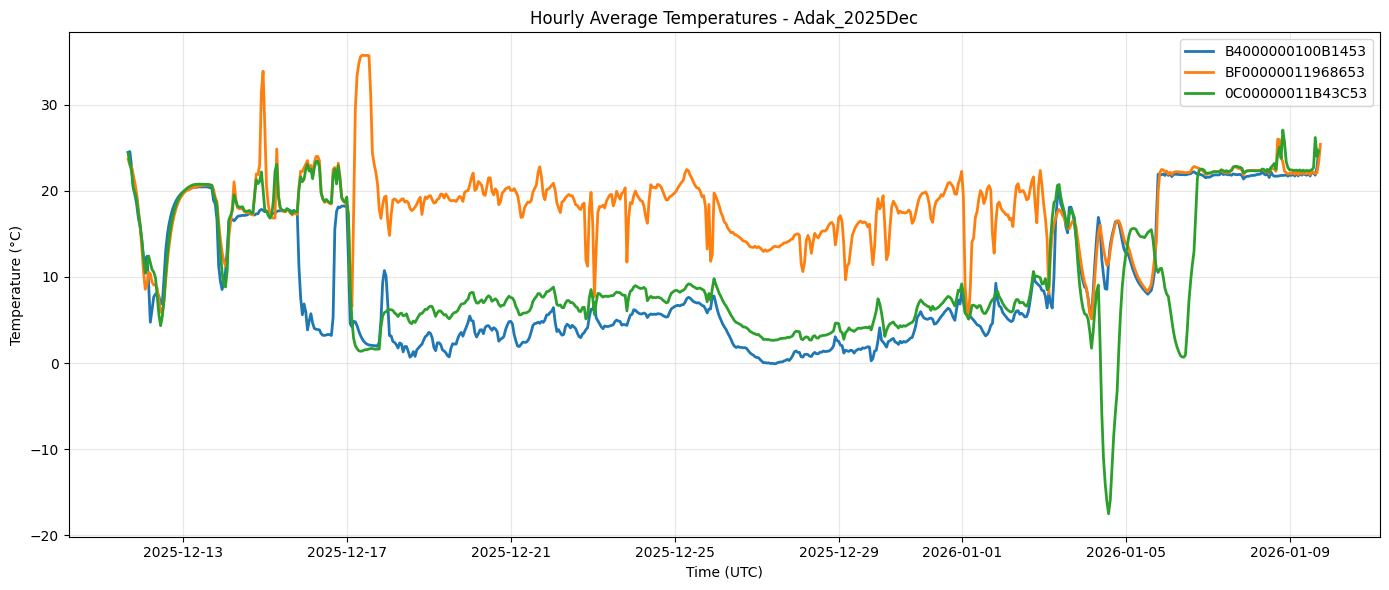

Original data points: 25,105
Hourly averages: 2,095


In [39]:
# Resample to hourly averages for each sensor
hourly_data = []

for sensor in df['sensor_registration'].unique():
    sensor_data = df[df['sensor_registration'] == sensor].copy()
    sensor_data = sensor_data.set_index('datetime_utc')
    
    hourly = sensor_data['value_c'].resample('1H').mean()
    hourly_df = hourly.to_frame().reset_index()
    hourly_df['sensor'] = sensor
    hourly_data.append(hourly_df)

hourly_df = pd.concat(hourly_data, ignore_index=True)

# Plot hourly averages
plt.figure(figsize=(14, 6))

for sensor in hourly_df['sensor'].unique():
    sensor_data = hourly_df[hourly_df['sensor'] == sensor]
    plt.plot(sensor_data['datetime_utc'], sensor_data['value_c'], label=sensor, linewidth=2)

plt.xlabel('Time (UTC)')
plt.ylabel('Temperature (°C)')
plt.title(f'Hourly Average Temperatures - {DEPLOYMENT}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Original data points: {len(df):,}")
print(f"Hourly averages: {len(hourly_df):,}")